In [25]:
import math
import lucene
import time
import nltk
import itertools
import numpy as np
from tqdm import tqdm
from java.io import File
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from collections import defaultdict
from org.apache.lucene.store import FSDirectory
from org.apache.lucene.util import BytesRefIterator
from org.apache.lucene.index import DirectoryReader, Term
from org.apache.lucene.analysis.en import EnglishAnalyzer
from org.apache.lucene.analysis.core import WhitespaceAnalyzer
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.search import IndexSearcher, BooleanQuery, BooleanClause, TermQuery, BoostQuery
from org.apache.lucene.search.similarities import BM25Similarity, LMJelinekMercerSimilarity, LMDirichletSimilarity
lucene.initVM()

In [26]:
index_path = './index-enwiki'   #wiki index path
directory = FSDirectory.open(File(index_path).toPath())
indexReader = DirectoryReader.open(directory)

In [27]:
indexReader.numDocs()

6584626

In [28]:
import pickle
doc_cluster_path = './wiki-cluster/wiki_200-1001-clusters_dim_100_n_init_10.pickle' #wiki pages cluster path

with open(doc_cluster_path, 'rb') as handle:
    doc_clusters = pickle.load(handle)

In [29]:
cluster_numbers = doc_clusters[300]     #for wiki 300 cluster size was choosen
document_dict = {} 
for index, cluster_number in enumerate(cluster_numbers):
    if cluster_number not in document_dict:
        document_dict[cluster_number] = [index]
    else:
        document_dict[cluster_number].append(index)


In [ ]:
#

In [14]:
# document_dict[299]

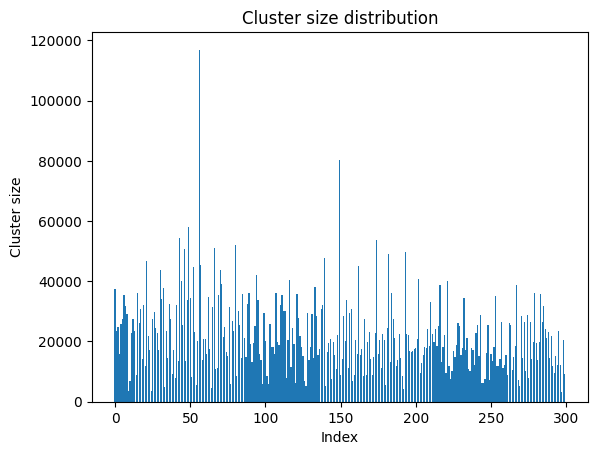

In [18]:
# Extract keys and corresponding list lengths
keys = list(document_dict.keys())
list_lengths = [len(lst) for lst in document_dict.values()]

# Create the histogram
plt.bar(keys, list_lengths)

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Cluster size')
plt.title('Cluster size distribution')

# Display the histogram
plt.savefig('cluster-size-distrubution-wiki.png', dpi=500)
plt.show()


In [21]:
min(list_lengths), max(list_lengths)

(3321, 116898)

In [24]:
cluster_numbers

array([156,  31, 275, ...,  95, 133, 299], dtype=int32)

In [12]:
len(document_dict)

300

In [53]:
indexReader.getSumTotalTermFreq('CONTENT')

2104495725

In [41]:
from tqdm import tqdm
none_docids = []
def concatenate_doc(cluster_dict):
    N = indexReader.numDocs()
    docVec = {}
    D = 0                                 

    for luceneDocid in tqdm(cluster_dict, leave=False):
        
        terms = indexReader.getTermVector(luceneDocid, 'CONTENT')
        if terms == None:
            # print('None term', terms)
            # print(luceneDocid)
            none_docids.append(luceneDocid)
        else:
            iterator = terms.iterator()
            for term in BytesRefIterator.cast_(iterator):
                t = term.utf8ToString()
                tf = iterator.totalTermFreq()  
                D += tf
                if t.isalpha() and 10>len(t)>3:
                    if t not in docVec:
                        docVec[t] = tf
                    else:
                        docVec[t] = docVec[t] + tf

    return docVec, D

In [59]:
# with open('./wiki_lucene_docid_none.pickle', 'wb') as handle:
#     pickle.dump(none_docids, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
def P_jm(doc_vec, lamb=0.4):
    totalTF = indexReader.getSumTotalTermFreq("CONTENT")

    doc_vector, D = doc_vec
    prob_dict =  defaultdict(lambda: [0, 0]) 
 

    for key, value in doc_vector.items():

        cf = indexReader.totalTermFreq(Term('CONTENT', key))/totalTF
        prob_dict[key][0] = (1- lamb)*(value/D) + lamb*(cf)
        prob_dict[key][1] = cf
    return prob_dict
        

In [43]:
def relative_entropy(p_d):
    rel_ent = {}
    for key, val in p_d.items():
        rel_ent[key] = val[0]*np.log(val[0]/val[1])

    temp_list = sorted(rel_ent.items(), key=lambda x:x[1], reverse=True)
    sorted_rel_ent = dict(temp_list)
    return sorted_rel_ent

In [44]:
# id_query = {}
# for key in tqdm(document_dict):

#     doc = document_dict[key]
#     doc_vec = concatenate_doc(doc)
#     if doc_vec == None:
#         print('Empty doc_vec:', doc_vec)
#     else:
#         p = P_jm(doc_vec)
#         query =  ' '.join(list(relative_entropy(p).keys()))
#         id_query[key] = query

id_query = {}
for key in tqdm(document_dict):

    doc = document_dict[key]
    doc_vec = concatenate_doc(doc)
    if doc_vec == None:
        pass
        # print('Empty doc_vec:', doc_vec)
    else:
        p = P_jm(doc_vec)
        rel_ent = relative_entropy(p)
        threshold = sum(rel_ent.values())*0.0
        # Filter the dictionary to keep only terms above the threshold
        filtered_data = {term: score for term, score in rel_ent.items() if score > threshold}
        query =  ' '.join(list(filtered_data.keys()))
        id_query[key] = query

100%|██████████| 300/300 [2:16:36<00:00, 27.32s/it]  


In [45]:
# with open('./temp_generated_queries/300_cluster_query_wiki_10_len_3.pickle', 'wb') as handle:
#     pickle.dump(id_query, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('./generated_query/300_cluster_query_wt10g.pickle', 'rb') as handle:
#     id_q = pickle.load(handle)

In [46]:
from tqdm import tqdm
unigram = set()
bigram = set()
for k in tqdm(id_query):
    unigram =  unigram | set(id_query[k].split())  
    
    bigram_temp = list(nltk.bigrams(id_query[k].split()))
    bigram_list = [' '.join(item) for item in bigram_temp]
    bigram = bigram | set(bigram_list)  

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [10:54<00:00,  2.18s/it]


In [72]:
id_query[9]

'speci china diaphoru hybomitra found yunnan triniti meleonoma isachn famili proturan bickel melastoma chines apiospora endem stenoloba diostracu angelica genu habitat yoshida aden sichuan eclect neisser asia wang ainsworth gafița caiu vietnam turtl taiwan guangxi tree valemax pepper fomitopsi styrax plant quercu postia india yanikian myanmar cyprinid militia hainan subspeci grichanov saigusa whale ukrainian guizhou stourzh theeran nosu kononenko scutig carpinu porpidia frog bluke southern bank phoeb yang agelena forest peterhous review cardamom thailand acer amolop labussièr lasanc greathe islam allend gansu weimann beatl mauremi guangdong japan bambusa acropsilu northern flower buriram amend grootaert duze john beitz masaka america fonaci romm korea winner pembrok nuthatch kauna toad pika agriad murraya distribut kannami unknown pakuan parken fujian vale manion transfer ukrain confess descript retriev becker tibet right roord soviet iucn known vole conder fruit describ ottavino fish 

In [62]:
# bigram

In [47]:
len(unigram), len(bigram)

(5317643, 33720391)

In [48]:
len(unigram) + len(bigram)

39038034

In [49]:
cqg = unigram | bigram

In [63]:
cqg

{'canpaign käihkö',
 'goettel türi',
 'sporet liesa',
 'montréal lennart',
 'battist panopoli',
 'tabvli',
 'kisaragi cower',
 'jout salvarani',
 'الصحوة koyamaki',
 'scrovegni dunbar',
 'shoshana yoho',
 'lusih',
 'unrecogn hunsrück',
 'litiji tufflei',
 'nilat',
 'poomsa reddo',
 'kamilch unvault',
 'domnick capless',
 'gonipteru murugesu',
 'apaadi rotachat',
 'raspail orzeł',
 'bagariu atzori',
 'henui jižní',
 'charuymaq sarab',
 'cávado touraj',
 'ghaddar kilton',
 'todorovo vietvodao',
 'اشكور cookenboo',
 'amadí prizegiv',
 'chittussi ciuha',
 'emberw sachkov',
 'rahara strimpl',
 'techint oyashio',
 'kannur marrano',
 'haircvt handipet',
 'edict diepholz',
 'rudhirá ruðro',
 'porto tutt',
 'sôji kahahaha',
 'chhibber pavletich',
 'szeregi waadhoek',
 'kigami zugbu',
 'dimpl luce',
 'conclav laze',
 'jinshadao',
 'manaket',
 'faxian getica',
 'kaskuta',
 'fend brigham',
 'luini bermbach',
 'moundsvil boteach',
 'xiangtan pinguin',
 'callisen alfonsu',
 'trophikó',
 'maiestati g

In [50]:
import json
with open('./generated_queries/wiki_cqg_unigram_bigram_10_len_3.json', 'w') as f:  # dumping quries in json file
    json.dump(list(cqg), f)

In [151]:
# bigrm = list(nltk.bigrams(query.split()))
